In [1]:
import mlrun

In [2]:
from mlrun.artifacts import DatasetArtifact,Artifact

In [3]:
project = mlrun.load_project('./')

In [4]:
project.register_artifacts()

In [5]:
project.save()

#### Project YAML

In [6]:
print(project.to_yaml())

kind: project
metadata:
  name: clone-test-shapira
spec:
  functions:
  - url: ./fetch_data.py
    name: fetch_data
    kind: job
    image: mlrun/mlrun
    handler: fetch_data
  - url: ./trainier.py
    name: trainer
    kind: job
    image: mlrun/mlrun
    handler: train
  - url: ./serving.yaml
    name: serving
  workflows: []
  artifacts:
  - kind: dataset
    metadata:
      project: clone-test-shapira
      key: cancer-dataset
    spec:
      format: csv
    status:
      state: created
  artifact_path: s3://testbucket-igz-temp/
  source: ''
  desired_state: online



In [7]:
dataset = project.get_artifact('cancer-dataset')

In [8]:
dataset.target_path

's3://testbucket-igz-temp/cancer-dataset.csv'

In [9]:
job_function_run = project.run_function('fetch_data',inputs={'dataset' : dataset.target_path})

> 2022-12-08 10:50:59,109 [info] starting run fetch-data-fetch_data uid=ea72d7389bcd4faa985c1d5fc8e9e347 DB=http://mlrun-api:8080
> 2022-12-08 10:50:59,280 [info] Job is running in the background, pod: fetch-data-fetch-data-6dpqt
> 2022-12-08 10:51:03,358 [info] saving dataframe to s3
> 2022-12-08 10:51:04,000 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
clone-test-shapira,...c8e9e347,0,Dec 08 10:51:02,completed,fetch-data-fetch_data,v3io_user=shapirakind=jobowner=shapiramlrun/client_version=1.2.1-rc2host=fetch-data-fetch-data-6dpqt,dataset,,,dataset


> 2022-12-08 10:51:05,717 [info] run executed, status=completed


In [10]:
job_function_run.outputs

{'dataset': 'store://artifacts/clone-test-shapira/fetch-data-fetch_data_dataset:ea72d7389bcd4faa985c1d5fc8e9e347'}

In [11]:
trainer_run = project.run_function('trainer',inputs = {"dataset":job_function_run.outputs['dataset']},params = {"n_estimators": 100, "learning_rate": 1e-1, "max_depth": 3})

> 2022-12-08 10:51:05,755 [info] starting run trainer-train uid=7d1f6aaef5674c60b909959a0847145b DB=http://mlrun-api:8080
> 2022-12-08 10:51:06,140 [info] Job is running in the background, pod: trainer-train-b6k9t
> 2022-12-08 10:51:11,498 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
clone-test-shapira,...0847145b,0,Dec 08 10:51:09,completed,trainer-train,v3io_user=shapirakind=jobowner=shapiramlrun/client_version=1.2.1-rc2host=trainer-train-b6k9t,dataset,n_estimators=100learning_rate=0.1max_depth=3,,model


> 2022-12-08 10:51:12,595 [info] run executed, status=completed


In [12]:
serving_func = project.deploy_function('serving',models=[{'key':'cancer-classifier','model_path':trainer_run.outputs["model"], 'class_name':'mlrun.frameworks.sklearn.SklearnModelServer'}])

> 2022-12-08 10:51:12,618 [info] Starting remote function deploy
2022-12-08 10:51:12  (info) Deploying function
2022-12-08 10:51:12  (info) Building
2022-12-08 10:51:12  (info) Staging files and preparing base images
2022-12-08 10:51:12  (info) Building processor image
2022-12-08 10:52:27  (info) Build complete
2022-12-08 10:52:33  (info) Function deploy complete
> 2022-12-08 10:52:34,573 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-clone-test-shapira-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['clone-test-shapira-serving-clone-test-shapira.default-tenant.app.jmglmvqnganv.iguazio-cd1.com/']}


In [14]:
my_data = {"inputs"
           :[[
               1.371e+01, 2.083e+01, 9.020e+01, 5.779e+02, 1.189e-01, 1.645e-01,
               9.366e-02, 5.985e-02, 2.196e-01, 7.451e-02, 5.835e-01, 1.377e+00,
               3.856e+00, 5.096e+01, 8.805e-03, 3.029e-02, 2.488e-02, 1.448e-02,
               1.486e-02, 5.412e-03, 1.706e+01, 2.814e+01, 1.106e+02, 8.970e+02,
               1.654e-01, 3.682e-01, 2.678e-01, 1.556e-01, 3.196e-01, 1.151e-01]
            ]
}
serving_func.function.invoke("/", body=my_data)

> 2022-12-08 10:55:57,395 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-clone-test-shapira-serving.default-tenant.svc.cluster.local:8080/'}


{'id': '4c09678a-942d-4777-9a1d-266140154594',
 'model_name': 'cancer-classifier',
 'outputs': [0]}

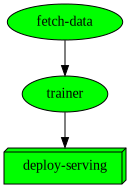

uid,start,state,name,parameters,results
...8ba7285e,Dec 08 10:56:36,completed,trainer,,
...60ed18d1,Dec 08 10:56:11,completed,fetch-data,,


7e1d2899-2f86-42a9-b9ba-d3547b94bec4

In [15]:
project.run(workflow_path='workflow.py',watch=True)